In [1]:
import pandas as pd

df = pd.read_csv("framingham.csv")

In [2]:
print(df.head())

   male  age  education  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
0     1   39        4.0              0         0.0     0.0                0   
1     0   46        2.0              0         0.0     0.0                0   
2     1   48        1.0              1        20.0     0.0                0   
3     0   61        3.0              1        30.0     0.0                0   
4     0   46        3.0              1        23.0     0.0                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
0             0         0    195.0  106.0   70.0  26.97       80.0     77.0   
1             0         0    250.0  121.0   81.0  28.73       95.0     76.0   
2             0         0    245.0  127.5   80.0  25.34       75.0     70.0   
3             1         0    225.0  150.0   95.0  28.58       65.0    103.0   
4             0         0    285.0  130.0   84.0  23.10       85.0     85.0   

   TenYearCHD  
0           0  
1           0  
2 

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4240 non-null   int64  
 1   age              4240 non-null   int64  
 2   education        4135 non-null   float64
 3   currentSmoker    4240 non-null   int64  
 4   cigsPerDay       4211 non-null   float64
 5   BPMeds           4187 non-null   float64
 6   prevalentStroke  4240 non-null   int64  
 7   prevalentHyp     4240 non-null   int64  
 8   diabetes         4240 non-null   int64  
 9   totChol          4190 non-null   float64
 10  sysBP            4240 non-null   float64
 11  diaBP            4240 non-null   float64
 12  BMI              4221 non-null   float64
 13  heartRate        4239 non-null   float64
 14  glucose          3852 non-null   float64
 15  TenYearCHD       4240 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 530.1 KB
None


In [4]:
missing_counts = df.isnull().sum()
print(missing_counts[missing_counts > 0])

education     105
cigsPerDay     29
BPMeds         53
totChol        50
BMI            19
heartRate       1
glucose       388
dtype: int64


In [5]:
cols_to_impute = ["education", "cigsPerDay", "BPMeds", "totChol", "BMI", "heartRate", "glucose"]
for col in cols_to_impute:
    mode_value = df[col].mode()[0]
    df[col].fillna(mode_value, inplace=True)


In [6]:
missing_counts = df.isnull().sum()
print(missing_counts[missing_counts > 0])

Series([], dtype: int64)


In [8]:
from sklearn.preprocessing import StandardScaler
X = df.drop(columns=["TenYearCHD"])
y = df["TenYearCHD"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [9]:
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_scaled, y)
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': selector.scores_
}).sort_values(by='Score', ascending=False)
print(feature_scores)

            Feature       Score
1               age  226.853168
10            sysBP  208.158627
7      prevalentHyp  137.799103
11            diaBP   91.160759
14          glucose   63.788499
8          diabetes   40.543047
0              male   33.358835
5            BPMeds   31.909790
9           totChol   28.600015
12              BMI   21.179219
6   prevalentStroke   16.259940
4        cigsPerDay   14.668063
2         education   11.938889
13        heartRate    2.214058
3     currentSmoker    1.603605


In [10]:
top_features = ['age', 'sysBP', 'prevalentHyp', 'diaBP', 'glucose', 'diabetes', 'male', 'BPMeds']
X_selected = X_scaled[top_features]

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

In [15]:
from sklearn.svm import SVC
svm_balanced = SVC(kernel='linear', probability=True, class_weight='balanced')
svm_balanced.fit(X_train, y_train)

SVC(class_weight='balanced', kernel='linear', probability=True)

Confusion Matrix:
[[467 252]
 [ 47  82]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.65      0.76       719
           1       0.25      0.64      0.35       129

    accuracy                           0.65       848
   macro avg       0.58      0.64      0.56       848
weighted avg       0.81      0.65      0.70       848


ROC AUC Score: 0.69


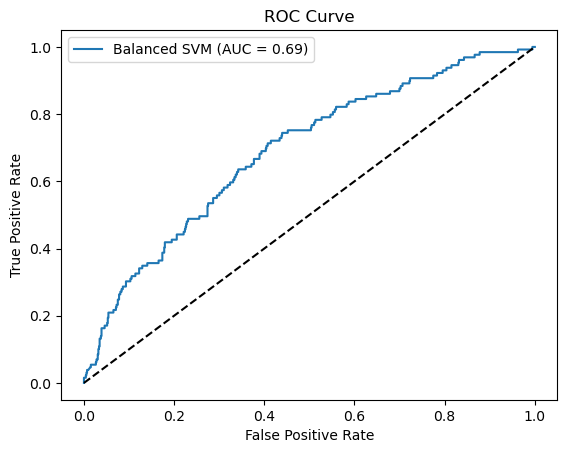

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_pred = svm_balanced.predict(X_test)
y_proba = svm_balanced.predict_proba(X_test)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

auc = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC Score: {auc:.2f}")

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'Balanced SVM (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [18]:
!pip install --upgrade scikit-learn imbalanced-learn

  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/a1/a6/c5b78606743a1f28eae8f11973de6613a5ee87366796583fb74c67d54939/scikit_learn-1.6.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for imbalanced-learn from https://files.pythonhosted.org/packages/9d/41/721fec82606242a2072ee909086ff918dfad7d0199a9dfd4928df9c72494/imbalanced_learn-0.13.0-py3-none-any.whl.metadata
  Obtaining dependency information for sklearn-compat<1,>=0.1 from https://files.pythonhosted.org/packages/f0/a8/ad69cf130fbd017660cdd64abbef3f28135d9e2e15fe3002e03c5be0ca38/sklearn_compat-0.1.3-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
    --------------------------------------- 0.1/11.1 MB 4.3 MB/s eta 0:00:03
   - -------------------------------------- 0.3/11.1 MB 4.2 MB/s eta 0:00:03
   -- ------------------------------------- 0.7/11.1 MB 5.5 MB/s eta 0:00:02
   --- -----------------------------------

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\suren\\anaconda\\Lib\\site-packages\\~klearn\\.libs\\msvcp140.dll'
Consider using the `--user` option or check the permissions.



In [19]:
from imblearn.over_sampling import SMOTE

In [20]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
print("After SMOTE:\n", y_train_sm.value_counts())

After SMOTE:
 TenYearCHD
0    2877
1    2877
Name: count, dtype: int64


Confusion Matrix:
[[464 255]
 [ 47  82]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.65      0.75       719
           1       0.24      0.64      0.35       129

    accuracy                           0.64       848
   macro avg       0.58      0.64      0.55       848
weighted avg       0.81      0.64      0.69       848


ROC AUC Score: 0.69


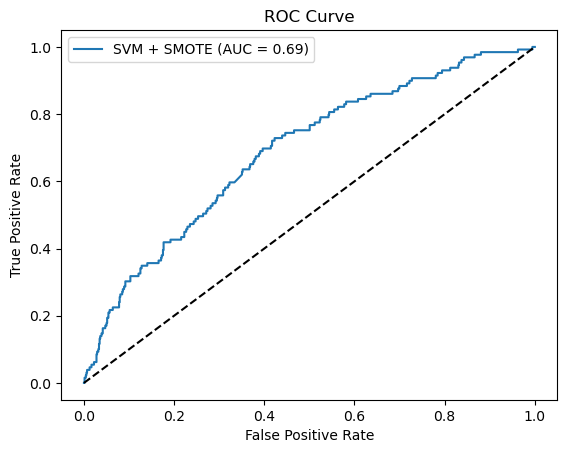

In [21]:
# Train the SVM
svm_smote = SVC(kernel='linear', probability=True)
svm_smote.fit(X_train_sm, y_train_sm)

# Evaluate
y_pred = svm_smote.predict(X_test)
y_proba = svm_smote.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

auc = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC Score: {auc:.2f}")

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'SVM + SMOTE (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Confusion Matrix:
[[719   0]
 [129   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       719
           1       0.00      0.00      0.00       129

    accuracy                           0.85       848
   macro avg       0.42      0.50      0.46       848
weighted avg       0.72      0.85      0.78       848


ROC AUC Score: 0.68


C:\Users\suren\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\suren\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\suren\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


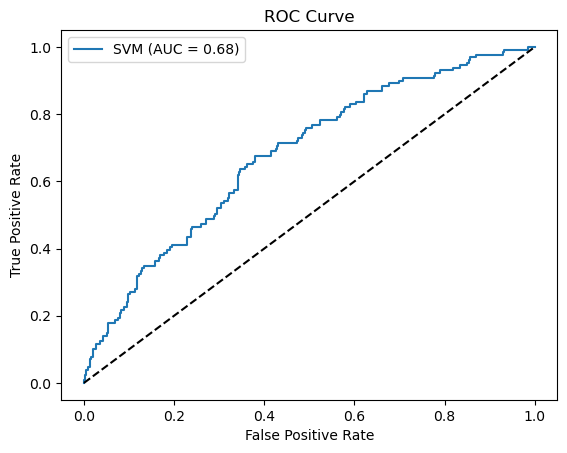

In [22]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
y_proba = svm.predict_proba(X_test)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

auc = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC Score: {auc:.2f}")

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'SVM (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()